###  GazePoint Guru2 test
* テストプログラム名：gazePoint_fix_3D_eye_pupiDia_blink.py
* テスト環境名：　Anaconda - spy
* 開発環境: Visual Studio Code 
* date:2022.10.13
* 開発者:門馬

* このipynbファイルは、socketで得られた生データを、各項目で数値データとして抽出
*    'ENABLE_SEND_PUPILMM',
*    'ENABLE_SEND_POG_FIX',
*    'ENABLE_SEND_EYE_RIGHT',
*    'ENABLE_SEND_EYE_LEFT',
*    'ENABLE_SEND_BLINK',

In [114]:
#インポートライブラリー
%matplotlib inline
#from  utils import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import math
from matplotlib.animation import ArtistAnimation

In [116]:
# 定数＆変数定義２０２２年１０月DELLのモニターにGazePoint を設置
# 実験で使用するモニターピクセルサイズ(モニターのカタログデータ)
SCREEN_X =1920
SCREEN_Y = 1080

# 実験で使用するモニターサイズ　ミリ単位(モニターのカタログデータ)
SCREEN_MM_X = 476.64
SCREEN_MM_Y = 268.11

# 1ピクセルあたりの長さ
px = SCREEN_MM_X/SCREEN_X
py = SCREEN_MM_Y/SCREEN_Y
print("px１ピクセルの長さ: {:.4f} mm".format(px))
print("py１ピクセルの長さ: {:.4f} mm".format(py))

px１ピクセルの長さ: 0.2482 mm
py１ピクセルの長さ: 0.2483 mm


In [117]:
#このノートで使用する関数

#xy_dfデータから速度Vxytを求める関数
def calc_velocity(df):
    x_v = df['FPOGX'].values
    y_v = df['FPOGY'].values 
    t= 1
    v_xyts = []
    for i in range(len(x_v)):
        if i > 1 and i < (len(x_v) - 2 ):
            v_xt = (x_v[i+2] + x_v[i +1] - x_v[i-1] - x_v[i -2])*SCREEN_MM_X/ 6*time_per_frame
            v_yt = (y_v[i+2] + y_v[i +1] - y_v[i-1] - y_v[i -2])*SCREEN_MM_Y/ 6*time_per_frame
            v_xyt = math.sqrt(v_xt*v_xt + v_yt*v_yt)
            v_xyts.append(v_xyt)
        else:
            v_xt = 0
            v_yt = 0
            v_xyt =0 
            v_xyts.append(v_xyt)
    return v_xyts

#xy_gp_velocityデータから加速度Acc_xytを求める関数
def calc_accel(df):
    v_xyts = df['xy_gp_velocity'].values
    ac_xyts = []
    for i in range(len(v_xyts)):
        if i > 0 and i < (len(v_xyts) - 1 ):
            ac_xyt = (v_xyts[i +1] - v_xyts[i-1])/ 2*time_per_frame
            ac_xyts.append(ac_xyt)
        else:
            ac_xyt = 0
            ac_xyts.append(ac_xyt)
    return ac_xyts

In [118]:
#Raw data　パスを指定
path =  ''

In [119]:
data= input("Please input a raw data name（date-time")
file_time = 'guru_time_' + data + '.csv'
file_gaze=   'guru_gaze_data_' + data + '.csv'
file_target = 'guru_ball_data_' + data + '.csv'
# file_time = 'guru_time_2022-10-26_10_05.csv'
# file_gaze=   'guru_gaze_data_2022-10-26_10_05.csv'
# file_target = 'guru_ball_data_2022-10-26_10_05.csv'
print(f'time data: {file_time}')

Please input a raw data name（date-time2022-10-26_10_05
time data: guru_time_2022-10-26_10_05.csv


In [120]:
#データの抽出.csv
df_time = pd.read_csv(file_time)
df = pd.read_csv(file_gaze)
df_tg = pd.read_csv(file_target)

In [121]:
#取得したデータの整形
#グルグルテストでのターゲット座標
df_tg= df_tg.iloc[:, 1:]
df_tg= df_tg.rename(columns = {'0':'x','1':'y'})





#　データ数の確認
num_raws, _  = df.shape
print(f'測定データの列数: {num_raws}')

""" 
必要なデータについて、抽出する為に、ＡＰＩマニュアルを参考に抽出する
'fixationPOG_x':FPOGX,'fixationPOG_y':FPOGY, 'flag_valid_data_fixation':FPOGV,
'3D left eye data x': LEYEX,'3D left eye data y': LEYEY,'3D left eye data z':LEYEZ ,flag 3D left': LPUPILV, 
'3D right eye data x': REYEX,'3D right eye data y': REYEY,'3D right eye data z': REYEZ ,'3D flag right': RPUPILV,
'Blinks': BKDUR, 'pupilDia_Left': LPMM, 'flagDia_L': LPMMV, pupilDia_Rgiht':RPMM, 'flagDia_R':  RPMMV

""" 
#tags =['FPOGX', 'FPOGY', 'LEYEX', 'LEYEY', 'LEYEZ' , 'LPUPILV', 'REYEX', 'REYEY', 'REYEZ', 'RPUPILV', 'BKDUR', 'LPMM', 'LPMMV', 'RPMM', 'LPMMV']
tags =['CNT','TIME','TIME_TICK','FPOGX', 'FPOGY', 'LEYEX', 'LEYEY', 'LEYEZ' , 'LPUPILV', 'REYEX', 'REYEY', 'REYEZ', 'RPUPILV', 'BKDUR', 'LPMM', 'RPMM']

# 生データから必要なデータを抽出するための空のDataFrameを作成
df_new = pd.DataFrame(np.zeros([num_raws, len(tags)]), columns= tags)

# 生データから作成した空のDataFrameに数値を埋めていく
for tag in tqdm(tags):
    for i in range(df.shape[0]):
        data_list = df.iloc[i, 1].split() # 必要なカラムを選択
        for sep_list in data_list:
            if tag in sep_list:
                if 'LPMMV' in sep_list or 'RPMMV' in sep_list:
                    continue

                else:    
                    m = re.findall('"([^"]*)"', sep_list)
                    if m != []:
                        m = float(m[0])
                        df_new[tag][i] = m


測定データの列数: 2674


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:25<00:00,  1.61s/it]


In [122]:
#測定開始からの経過時間に変更
df_new['TIME2'] = df_time['0']-  df_time['0'][0]
#統計データの表示
df_new.describe()

,CNT,TIME,TIME_TICK,FPOGX,FPOGY,LEYEX,LEYEY,LEYEZ,LPUPILV,REYEX,REYEY,REYEZ,RPUPILV,BKDUR,LPMM,RPMM,TIME2
count,2674.000000,2.674000e+03,2.674000e+03,2674.000000,2674.000000,2674.000000,2674.000000,2674.000000,2674.000000,2674.000000,2674.000000,2674.000000,2674.000000,2674.000000,2674.000000,2674.000000,2674.000000
mean,195874.377711,6.560057e+12,6.788624e+12,0.433440,0.441790,-0.032753,0.003487,0.630585,0.998504,0.036105,-0.005297,0.631848,0.995138,0.000068,3.720234,4.017352,22.220117
std,4027.760832,1.231537e+12,1.313301e+11,0.254630,0.363688,0.003145,0.001420,0.033942,0.038655,0.003641,0.002337,0.048829,0.069569,0.003498,0.371174,0.372948,12.857172
min,0.000000,0.000000e+00,0.000000e+00,-0.039070,-0.277120,-0.045240,-0.000530,0.000000,0.000000,0.000000,-0.008490,0.000000,0.000000,0.000000,2.883310,3.156080,0.000000
25%,194805.750000,6.790956e+12,6.790976e+12,0.213328,0.094950,-0.034797,0.002520,0.614610,1.000000,0.034380,-0.007188,0.613720,1.000000,0.000000,3.427853,3.841743,11.085947
50%,196412.500000,6.791240e+12,6.791240e+12,0.452420,0.480365,-0.033240,0.003120,0.631950,1.000000,0.035980,-0.006100,0.636890,1.000000,0.000000,3.745900,4.050765,22.205894
75%,197088.750000,6.791351e+12,6.791351e+12,0.651643,0.803895,-0.031470,0.004648,0.644360,1.000000,0.037535,-0.002883,0.643870,1.000000,0.000000,3.970967,4.235373,33.350481
max,197767.000000,6.791463e+12,6.791463e+12,2.332190,2.259790,0.000000,0.006860,0.940720,1.000000,0.045630,0.000000,0.695400,1.000000,0.180870,5.202660,5.494810,44.486142


In [123]:
#欠損値の有無
#df_new.isnull().sum()

In [124]:
#グルテスト時間
x= df_new.shape[0]
test_time= df_new['TIME2'][x-1]-df_new['TIME2'][0]
fps = x/test_time
time_per_frame = test_time/x
print("グルグルテスト時間: {:.2f}sec".format(test_time))
print("取得した画像データのフレームレートFPS: {:.4f}".format(fps))
print("１フレームあたりの時間: {:.2f}sec".format(time_per_frame))
print("画像データからの注視点（R)の検出率: {:.2f}%".format(df_new['RPUPILV'].sum()/x*100))

グルグルテスト時間: 44.49sec
取得した画像データのフレームレートFPS: 60.1086
１フレームあたりの時間: 0.02sec
画像データからの注視点（R)の検出率: 99.51%


Text(0, 0.5, 'Velocity(mm/msec)')

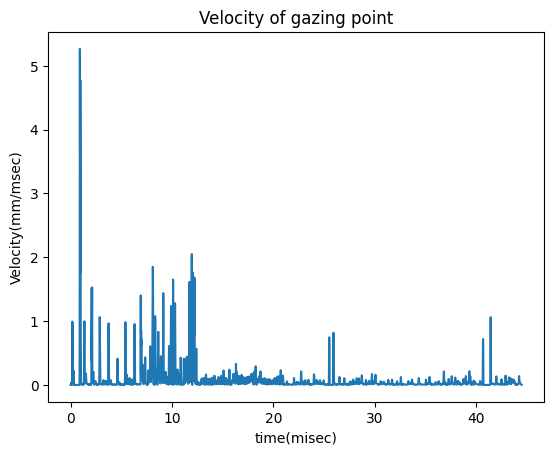

In [153]:
#視線の動き速度を計算
df_new['xy_gp_velocity'] =  calc_velocity(df_new)
#視線の動き速度をグラフでの表示
fig, ax = plt.subplots()
ax.plot(df_new['TIME2'], df_new['xy_gp_velocity'])
ax.set_title('Velocity of gazing point');
ax.set_xlabel('time(misec)')
ax.set_ylabel('Velocity(mm/msec)')

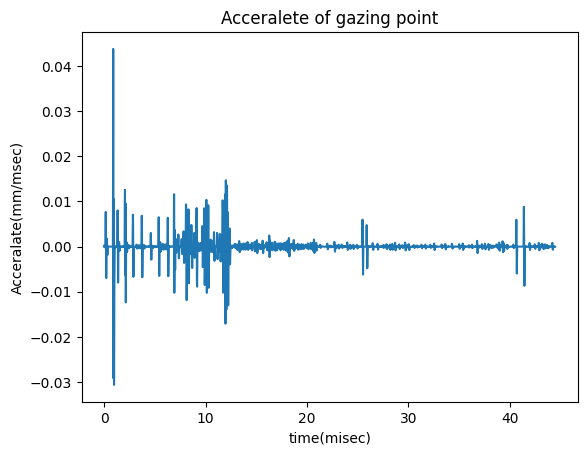

In [155]:
#緯線の加速度について計算
df_new['xy_gp_acc'] =  calc_accel(df_new)
fig , ax = plt.subplots()
ax.plot(df_new['TIME2'], df_new['xy_gp_acc'])
ax.set_title('Acceralete of gazing point');
ax.set_xlabel('time(misec)')
ax.set_ylabel('Acceralate(mm/msec)');

In [156]:
#ターゲットの座標の正規化
df_tg['norm_x']=((df_tg['x']-round(SCREEN_X/2))/SCREEN_X)*SCREEN_X/SCREEN_Y
df_tg['norm_y'] =((df_tg['y']-round(SCREEN_Y/2))/SCREEN_Y)
#df_tg.head()


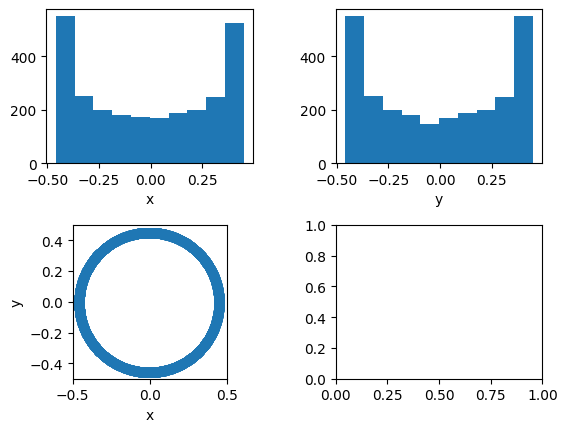

In [157]:
#ターゲットの座標の統計データ表示
fig ,axs = plt.subplots(2,2)
axs[0,0].hist(df_tg['norm_x'])
axs[0,0].set_xlabel('x')
axs[0,1].hist(df_tg['norm_y'])
axs[0,1].set_xlabel('y')
axs[1,0].scatter(df_tg['norm_x'],df_tg['norm_y'])
axs[1,0].set_xlabel('x')
axs[1,0].set_ylabel('y')
axs[1,0].set_xlim(-0.5, 0.5)
axs[1,0].set_ylim(-0.5, 0.5)
axs[1,0].set_aspect('equal', adjustable='box')

plt.subplots_adjust(wspace=0.4, hspace=0.4)

In [158]:
# 視線のデータを0.5シフト
df_new['norm_FPOGX'] = (df_new['FPOGX'] -0.5)
df_new['norm_FPOGY'] = (df_new['FPOGY'] -0.5)

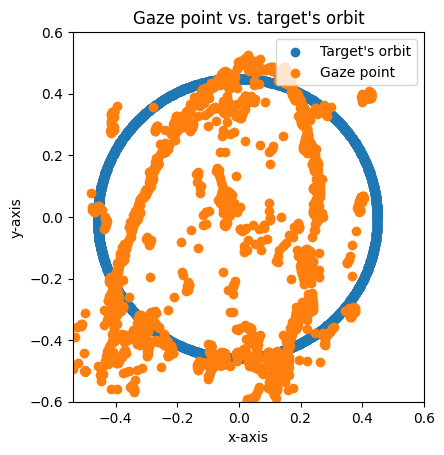

In [159]:
# データ抽出開始時間、終了時間を設定し、DataFrameからスライス

fig, ax = plt.subplots()

ax.scatter(df_tg['norm_x'],df_tg['norm_y'], label="Target's orbit")
ax
ax.scatter(df_new['norm_FPOGX'], df_new['norm_FPOGY'], label='Gaze point')
x_max =df_new['norm_FPOGX'].max()
x_min =df_new['norm_FPOGX'].min()
y_max =  df_new['norm_FPOGY'].max()
y_min =  df_new['norm_FPOGY'].min()
if x_max <= 0.5 or  x_max >= 1.0 :
    x_max = 0.6
if x_min >= -0.5 or x_min <= -1.0 :
    x_min = -0.6
if y_max <= 0.5 or y_max >= 1.0  :
    y_max = 0.6
if y_min >= -0.5 or y_min >= -1.0:
    y_min = -0.6    
    
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_aspect('equal', adjustable='box')
ax.set_title("Gaze point vs. target's orbit")
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.legend()
plt.subplots_adjust(wspace=0.4, hspace=0.4)

Text(0.5, 1.0, 'Heatmap of gaze point')

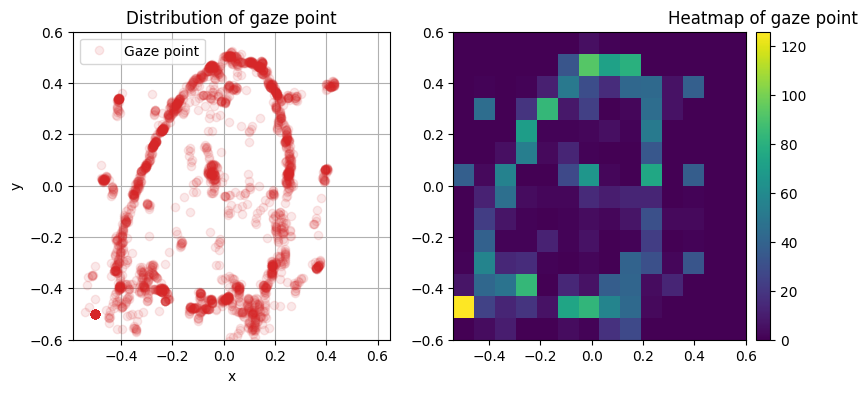

In [160]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
x_micro_dist = df_new['norm_FPOGX'].values
y_micro_dist = df_new['norm_FPOGY'].values
fig, axes = plt.subplots(ncols=2,figsize=(9,4))
ax = axes.ravel()
ax[0].plot(x_micro_dist ,y_micro_dist,"C3o",alpha=0.1, label = 'Gaze point')
ax[0].grid()
ax[0].axis('equal')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_title('Distribution of gaze point')
ax[0].legend()
#ax[0].set_aspect('equal', adjustable='box')

x_max =df_new['norm_FPOGX'].max()
x_min =df_new['norm_FPOGX'].min()
y_max =  df_new['norm_FPOGY'].max()
y_min =  df_new['norm_FPOGY'].min()
if x_max <= 0.5 or  x_max >= 1.0 :
    x_max = 0.6
if x_min >= -0.5 or x_min <= -1.0 :
    x_min = -0.6
if y_max <= 0.5 or y_max >= 1.0  :
    y_max = 0.6
if y_min >= -0.5 or y_min >= -1.0:
    y_min = -0.6    
ax[0].set_xlim(x_min, x_max)
ax[0].set_ylim(y_min, y_max)



xlim= ax[0].get_xlim()
ylim= ax[0].get_ylim()

xedges = np.linspace(xlim[0],xlim[1],15)
yedges = np.linspace(ylim[0],ylim[1],15)

H, xedge, yedge = np.histogram2d(x_micro_dist, y_micro_dist,bins=(xedges, yedges))

im = ax[1].imshow(H.T, interpolation='nearest', origin='lower',
          extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax)
plt.title('Heatmap of gaze point')

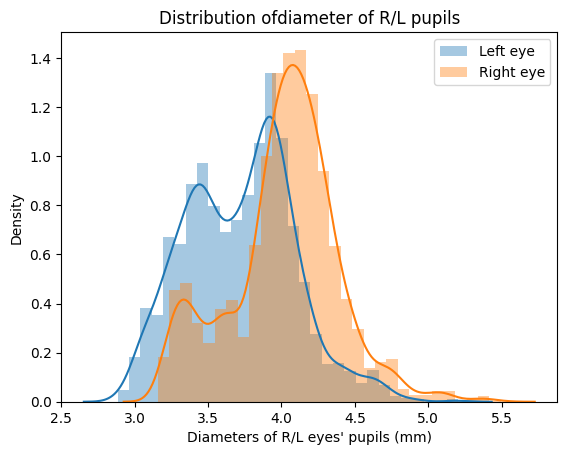

In [161]:
#Diameter of pupils

fig, ax = plt.subplots()
sns.distplot(df_new['LPMM'], bins=30, label= 'Left eye')
sns.distplot(df_new['RPMM'],bins=30, label ='Right eye')
ax.set_title('Distribution ofdiameter of R/L pupils')
ax.set_xlabel("Diameters of R/L eyes' pupils (mm)")#Diameter of pupils
ax.legend();



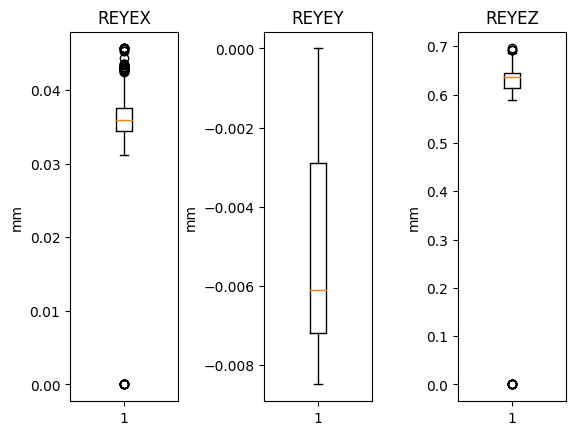

In [162]:
lst= ['REYEX', 'REYEY', 'REYEZ']
fig ,axs = plt.subplots(1,3)
for i in range(3):
    axs[i].boxplot(df_new[lst[i]])
    axs[i].set_title(lst[i])
    axs[i].set_ylabel('mm')

plt.subplots_adjust(wspace=0.8, hspace=0.4)    

In [163]:
#外れ値の削除（処理: 四分位範囲を計算してそこからバイアス倍分外側の値をバイアス倍分までにクリップする)
def replace_outlier(series, bias=1.5):
    #四分位数
    q1 = series.quantile(.25)
    q3 = series.quantile(.75)
    iqr = q3 - q1

    #外れ値の基準点
    outlier_min = q1 - (iqr) * bias
    outlier_max = q3 + (iqr) * bias

    print("outlier_min :" + str(outlier_min) + ", outlier_max :" + str(outlier_max))

    #外れ値をクリップする
    series = series.clip(outlier_min, outlier_max)
    return series

In [164]:
lst= ['REYEX', 'REYEY', 'REYEZ']
for i in range(3):
    sr = df_new[lst[i]]
    out= replace_outlier(sr, bias=1.5)
    df_new[lst[i]]= out
    

outlier_min :0.029647500000000004, outlier_max :0.0422675
outlier_min :-0.013645000000000001, outlier_max :0.0035749999999999996
outlier_min :0.568495, outlier_max :0.689095


In [165]:
#REYEX	REYEY	REYEZ


import plotly.express as px

fig = px.scatter_3d(df_new, 
                    x='REYEX', y='REYEY', z='REYEZ',
                   size_max=10,  # マーカーサイズの最大値を設定
    opacity=0.5,  # 不透明度を変更

)

 
                    
fig.show()

### 参考文献

 . https://iovs.arvojournals.org/article.aspx?articleid=2638575